In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import slot

plt.rcParams['animation.ffmpeg_path'] = 'C:/FFmpeg/bin/ffmpeg.exe'

In [12]:
class MAB:
    def __init__(self, bpl, slots, bandit_probs):
        
        # bandit의 확률 저장
        self.bandit_probs = bandit_probs
        # bet per line 저장
        self.bpl = bpl
        # slot의 수 저장
        self.N = len(slots)
        # platinum slot 저장
        self.slot_platinum = slot.game_platinum(bpl)
        # monster slot 저장
        self.slot_monster = slot.game_monster(bpl)
        # masquerade slot 저장
        # self.slot_masque = slot.game_masque(bpl)

    def draw(self, k):
        if k == 0:
            return self.slot_platinum.play_platinum(), np.max(self.bandit_probs) - self.bandit_probs[k]
        elif k == 1:
            return self.slot_monster.play_monster(), np.max(self.bandit_probs) - self.bandit_probs[k]


In [13]:
# bandit의 rtp 저장
rtp_values = np.array([0.583, 0.416])

# bet per line 값
bpl = 2000

# slot의 종류
slots = ['Platinum', 'monster']

In [14]:
# MAB class
mab = MAB(bpl, slots, rtp_values)

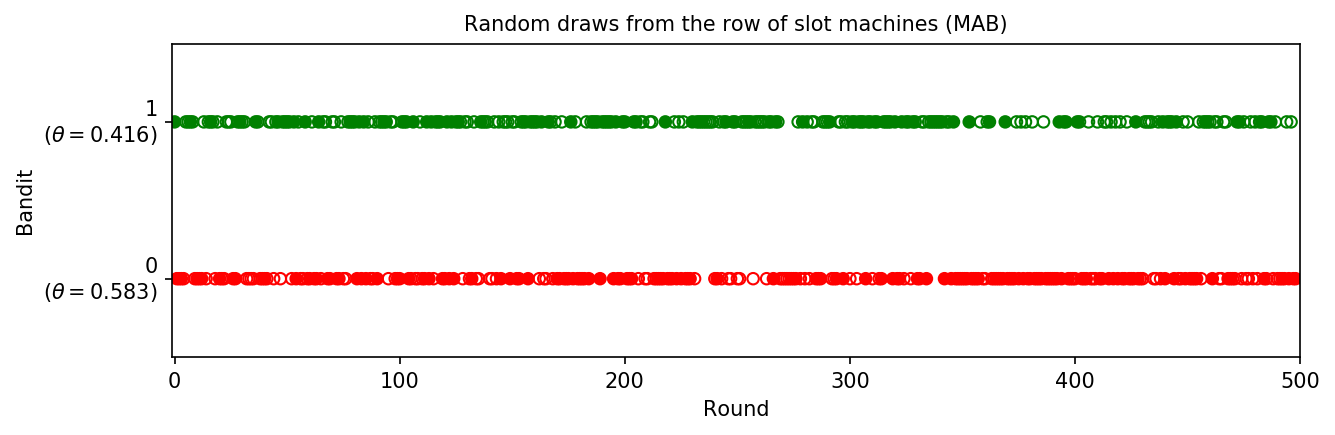

In [16]:
# draw 수
N_DRAWS = 500

# bandit의 수
N_BANDITS = len(slots)

# 누적 draw, bandit의 선택과 보상을 위한
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# visualization을 위한 list
k_list = []
reward_list = []

# fig 설정
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)
ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))

# 각 bandit의 색상
bandit_colors = ['red', 'green']

# draw 반복
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = np.random.choice(range(N_BANDITS),1)[0]
    reward, regret = mab.draw(k)
    
    if reward > 0:
        reward = 1
    else:
        reward = 0
    
    # 이 draw 정보 기록
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
    
    # bandit의 color list
    color_list = [bandit_colors[k] for k in k_list]
    
    # reward의 facecolor
    facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]    

# 데이터 initializing
scatter = ax.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);

# 시각화 타이틀
plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
ax.set_yticks([0,1])
ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, rtp_values[i]) for i in range(2)])
ax.tick_params(labelsize=10)
fig.tight_layout()

# update를 위한 함수
def animate(i):
    x = list(range(N_DRAWS))[:i]
    y = k_list[:i]
    scatter.set_offsets(np.c_[x, y])
    scatter.set_color(color_list[:i])
    scatter.set_facecolor(facecolor_list[:i])
    ax.set_yticks([0,1])
    ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, rtp_values[i]) for i in range(2)])
    ax.tick_params(labelsize=10)
    return (scatter,)


# animation 생성 함수
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=25, blit=True)

# 출력
HTML(anim.to_html5_video())

In [81]:
def get_beta_pdf(alpha, beta):
    X = np.linspace(0,1,1000)
    return X, beta_dist(1 + alpha,1 + beta).pdf(X)

In [82]:
def plot_MAB_experiment(decision_policy, N_DRAWS, bandit_probs, plot_title):

    # clearing past figures
    plt.close('all')

    # number of bandits
    N_BANDITS = len(bandit_probs)
    
    # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
    k_array = np.zeros((N_BANDITS,N_DRAWS))
    reward_array = np.zeros((N_BANDITS,N_DRAWS))
    
    # lists for accumulating draws, bandit choices and rewards
    k_list = []
    reward_list = []
    reward_switch = []

    # animation dict for the posteriors
    posterior_anim_dict = {i:[] for i in range(N_BANDITS)}

    # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=4, rowspan=3)
    ax2 = plt.subplot2grid((5, 4), (3, 0), rowspan=2)
    ax3 = plt.subplot2grid((5, 4), (3, 1), rowspan=2)
    ax4 = plt.subplot2grid((5, 4), (3, 2), rowspan=2)
    ax5 = plt.subplot2grid((5, 4), (3, 3), rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        k = decision_policy.choose_bandit(k_array, reward_array, N_BANDITS)
        reward, regret = mab.draw(k)

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)
        k_array[k, draw_number] = 1
        reward_array[k, draw_number] = reward
        
        if reward:
            reward_switch.append(1)
        else:
            reward_switch.append(0)
        
        """
        # sucesses and failures for our beta distribution
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
        """
        
        # calculating pdfs for each bandit
        for bandit_id in range(N_BANDITS):

            # pdf
            X, curve = get_beta_pdf(decision_policy.alpha[bandit_id], decision_policy.beta[bandit_id])

            # appending to posterior animation dict
            posterior_anim_dict[bandit_id].append({'X': X, 'curve': curve})

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_switch)]
        
        decision_policy.update(k, reward)
    
    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(2)])
    ax1.tick_params(labelsize=10)

    # titles of distribution plots
    ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
    ax4.set_title('Estimated $\\theta_2$', fontsize=10); ax5.set_title('Estimated $\\theta_3$', fontsize=10);

    # initializing with first data
    scatter = ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);
    dens1 = ax2.fill_between(posterior_anim_dict[0][0]['X'], 0, posterior_anim_dict[0][0]['curve'], color='red', alpha=0.7)
    dens2 = ax3.fill_between(posterior_anim_dict[1][0]['X'], 0, posterior_anim_dict[1][0]['curve'], color='green', alpha=0.7)
    #dens3 = ax4.fill_between(posterior_anim_dict[2][0]['X'], 0, posterior_anim_dict[2][0]['curve'], color='blue', alpha=0.7)
    #dens4 = ax5.fill_between(posterior_anim_dict[3][0]['X'], 0, posterior_anim_dict[3][0]['curve'], color='purple', alpha=0.7)

    # titles
    #plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
    #plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);

    # function for updating
    def animate(i):

        # clearing axes
        ax1.clear(); ax2.clear(); ax3.clear(); ax4.clear(); ax5.clear();

        # updating game rounds
        scatter = ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], 
                              linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # fixing properties of the plot
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax1.set_yticks([0,1])
        ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(2)])
        ax1.tick_params(labelsize=10)

        # updating distributions
        dens1 = ax2.fill_between(posterior_anim_dict[0][i]['X'], 0, posterior_anim_dict[0][i]['curve'], color='red', alpha=0.7)
        dens2 = ax3.fill_between(posterior_anim_dict[1][i]['X'], 0, posterior_anim_dict[1][i]['curve'], color='green', alpha=0.7)
        #dens3 = ax4.fill_between(posterior_anim_dict[2][i]['X'], 0, posterior_anim_dict[2][i]['curve'], color='blue', alpha=0.7)
        #dens4 = ax5.fill_between(posterior_anim_dict[3][i]['X'], 0, posterior_anim_dict[3][i]['curve'], color='purple', alpha=0.7)

        # titles of distribution plots
        ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
        ax4.set_title('Estimated $\\theta_2$', fontsize=10); ax5.set_title('Estimated $\\theta_3$', fontsize=10);
        
        # do not need to return 
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=100, blit=True)

    # fixing the layout
    fig.tight_layout()

    # showing
    return HTML(anim.to_html5_video())

In [83]:
# e-greedy policy
class eGreedyPolicy:
    
    # initializing
    def __init__(self, epsilon, bandit):
        
        # saving epsilon
        self.epsilon = epsilon
        self.alpha = np.ones(bandit.N, dtype=np.float)
        self.beta = np.ones(bandit.N, dtype=np.float)
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # sucesses and total draws
        total_reward = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # ratio of sucesses vs total
        rtp_value = total_reward / total_count
        
        # choosing best greedy action or random depending with epsilon probability
        if np.random.random() < self.epsilon:
            
            # returning random action, excluding best
            return np.random.choice(np.delete(list(range(N_BANDITS)), np.argmax(rtp_value)))
        
        # else return best
        else:
            
            # returning best greedy action
            return np.argmax(rtp_value)
        
    def update(self, k, reward):
        while(reward >= 60000):
            self.alpha[k] += 1
            reward -= 60000
        self.beta[k] += 1 - reward / 60000
        self.alpha[k] += reward / 60000

In [84]:
# instance of this class, let us use 0.10 for the random action probability
e_greedy_policy = eGreedyPolicy(0.10, mab)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


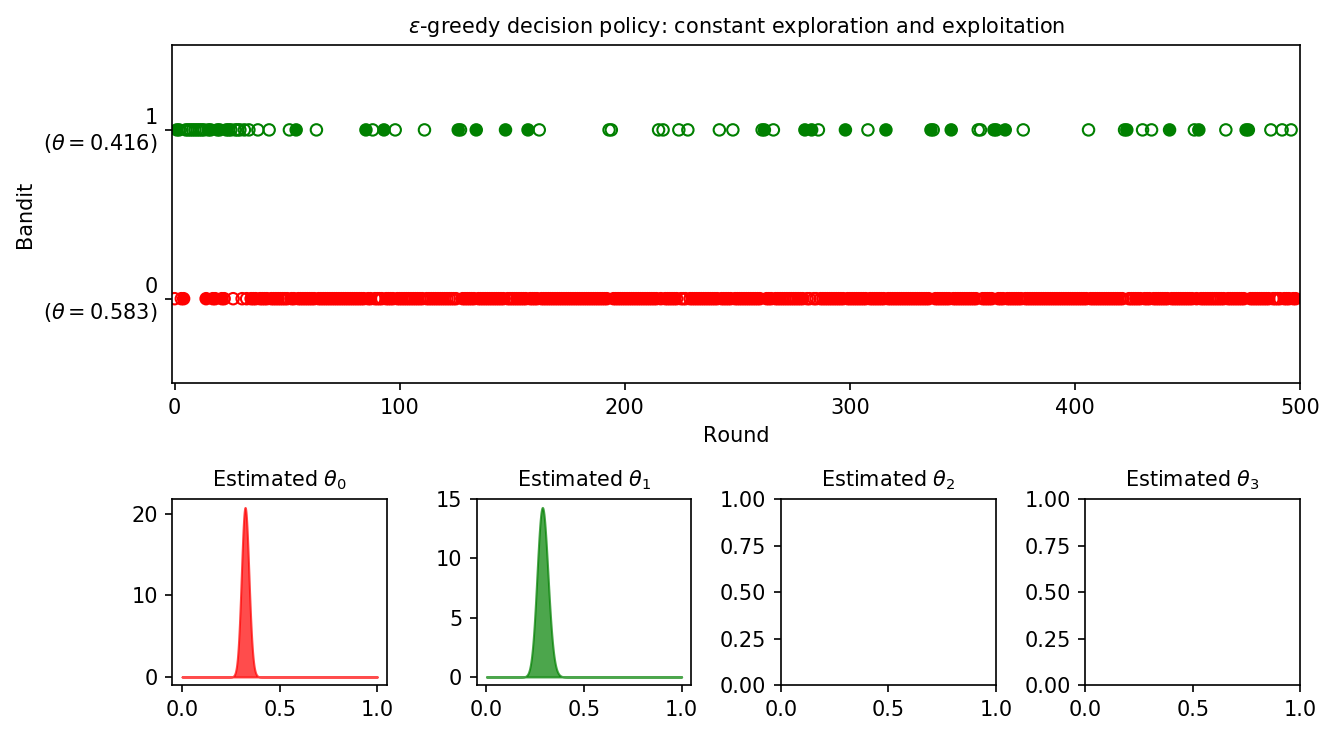

In [60]:
plot_MAB_experiment(e_greedy_policy, 200, mab.bandit_probs, '$\epsilon$-greedy decision policy: constant exploration and exploitation')

In [85]:
# ucb policy
class UCBPolicy:
    
    # initializing
    def __init__(self, bandit):
        
        self.alpha = np.ones(bandit.N, dtype=np.float)
        self.beta = np.ones(bandit.N, dtype=np.float)
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # sucesses and total draws
        total_reward = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # ratio of sucesses vs total
        rtp_value = total_reward / (total_count * 60000)
        
        # computing square root term
        sqrt_term = np.sqrt(2*np.log(np.sum(total_count))/total_count)
        
        # returning best greedy action
        return np.argmax(rtp_value + sqrt_term)
    
    def update(self, k, reward):
        while(reward >= 60000):
            self.alpha[k] += 1
            reward -= 60000
        self.beta[k] += 1 - reward / 60000
        self.alpha[k] += reward / 60000

In [86]:
ucb_policy = UCBPolicy(mab)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


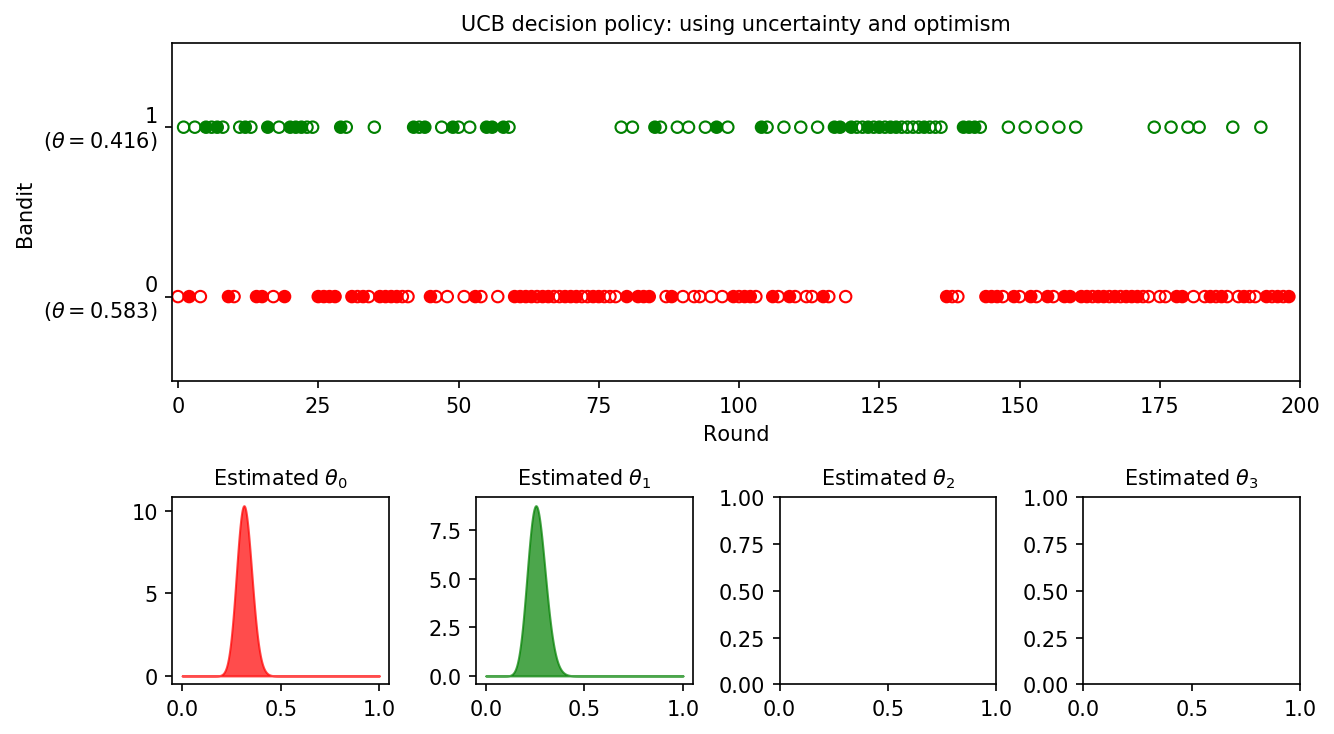

In [80]:
plot_MAB_experiment(ucb_policy, 200, mab.bandit_probs, 'UCB decision policy: using uncertainty and optimism')

In [87]:
class TSPolicy:
    
    # initializing
    def __init__(self, bandit):
        
        self.alpha = np.ones(bandit.N, dtype=np.float)
        self.beta = np.ones(bandit.N, dtype=np.float)
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):

        # list of samples, for each bandit
        samples_list = []
        
        # sucesses and total draws
        total_reward = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # ratio of sucesses vs total
        rtp_value = total_reward / total_count
                    
        # drawing a sample from each bandit distribution
        samples_list = [np.random.beta(self.alpha[bandit_id], self.beta[bandit_id]) for bandit_id in range(n_bandits)]
                                
        # returning bandit with best sample
        return np.argmax(samples_list)
    
    def update(self, k, reward):
        while(reward >= 60000):
            self.alpha[k] += 1
            reward -= 60000
        self.beta[k] += 1 - reward / 60000
        self.alpha[k] += reward / 60000

In [88]:
ts_policy = TSPolicy(mab)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


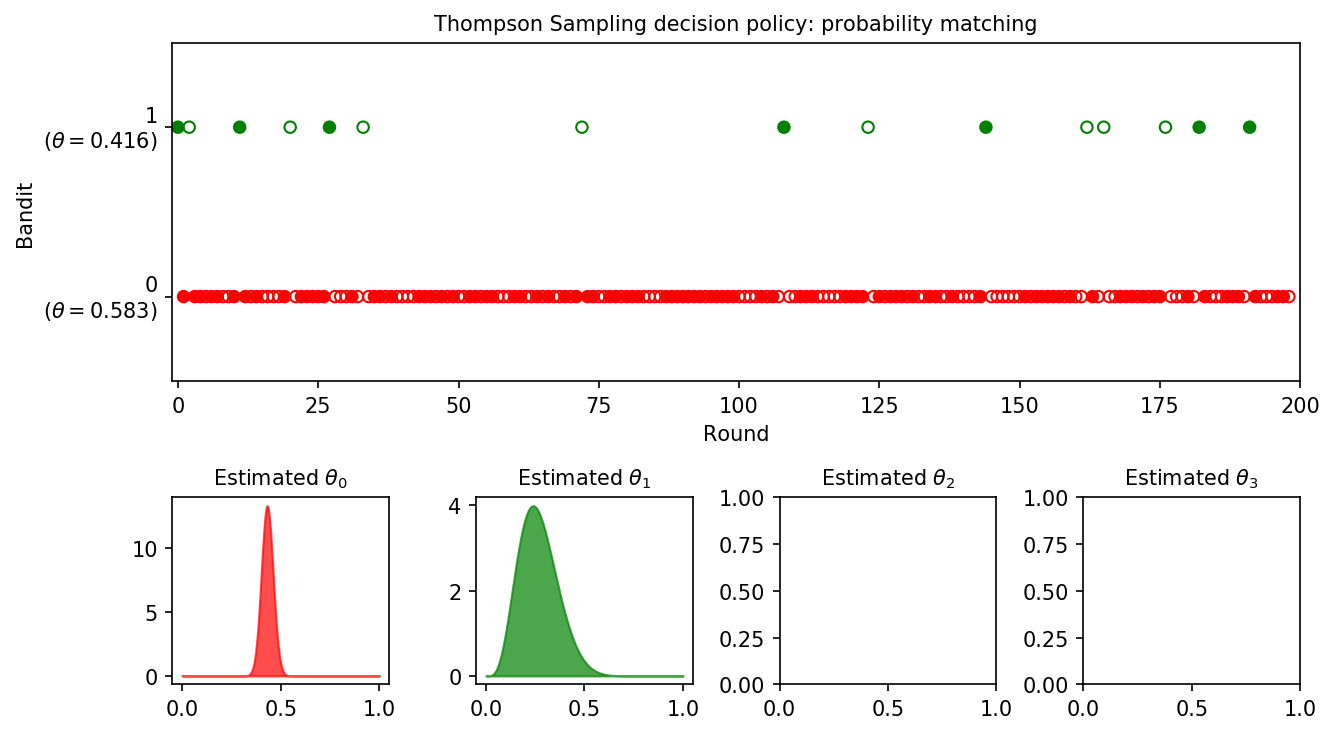

In [67]:
plot_MAB_experiment(ts_policy, 200, mab.bandit_probs, 'Thompson Sampling decision policy: probability matching')

In [89]:

#### SIMULATION ####
# round 횟수
N_ROUNDS = 10000
# simulation 횟수
N_SIMULATIONS = 100

# 각각의 decision policy를 저장할 dict
dp_dict = {'e_greedy': e_greedy_policy,
           'ucb': ucb_policy,
           'ts': ts_policy}

# 각 algorithm과 simulation의 결과를 저장할 dict
result_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                            'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                            'regret_array': np.zeros((1,N_ROUNDS))[0]},
               'ucb': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                       'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                       'regret_array': np.zeros((1,N_ROUNDS))[0]},
               'ts': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                      'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                      'regret_array': np.zeros((1,N_ROUNDS))[0]}
               }

# 각 알고리즘별 반복
for key, decision_policy in dp_dict.items():
    
    # progress를 print
    print(key, decision_policy)
    
    # 각 시뮬레이션 반복
    for simulation in tqdm(range(N_SIMULATIONS)):
        
        # 누적 draw 횟수, bandit 선택과 보상, regret을 저장할 numpy array 생성
        k_array = np.zeros((N_BANDITS,N_ROUNDS))
        reward_array = np.zeros((N_BANDITS,N_ROUNDS))
        regret_array = np.zeros((1,N_ROUNDS))[0]
        
        # 각 라운드 반복
        for round_id in range(N_ROUNDS):
            
            # arm을 선택하고 draw
            k = decision_policy.choose_bandit(k_array, reward_array, N_BANDITS)
            reward, regret = mab.draw(k)
            
            # 이 draw에 대한 정보를 기록
            k_array[k, round_id] = 1
            reward_array[k, round_id] = reward
            regret_array[round_id] = regret
            
            decision_policy.update(k, reward)
        
        # 이 simulation에 대한 결과
        result_dict[key]['k_array'] += k_array
        result_dict[key]['reward_array'] += reward_array
        result_dict[key]['regret_array'] += regret_array

e_greedy <__main__.eGreedyPolicy object at 0x0000020F9642E080>


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:35<00:00,  8.05s/it]


ucb <__main__.UCBPolicy object at 0x0000020F9492BE80>


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:33<00:00,  8.12s/it]


ts <__main__.TSPolicy object at 0x0000020F952FA438>


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:08<00:00,  8.38s/it]


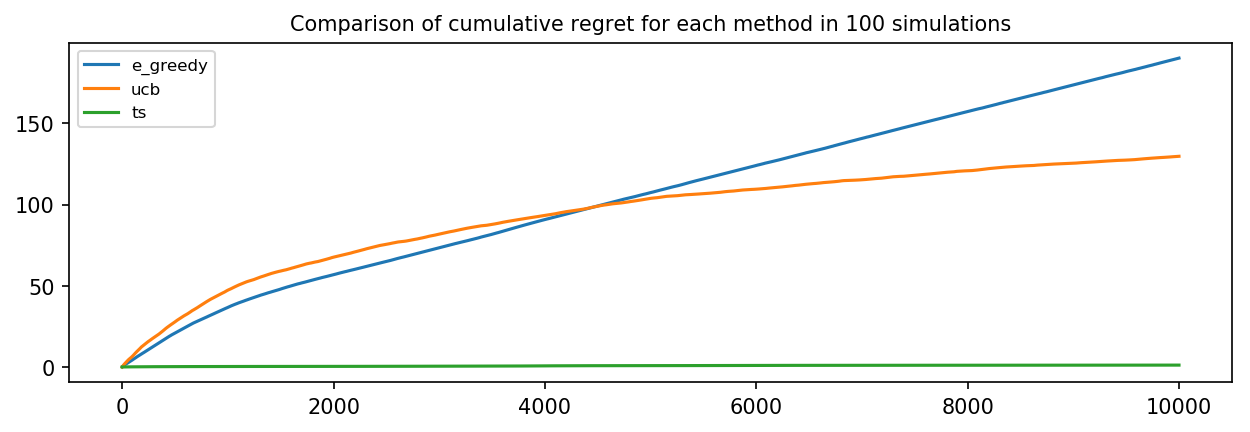

In [90]:

# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# loop for each decision policy
for policy in ['e_greedy','ucb','ts']:
    
    # plotting data
    plt.plot(np.cumsum(result_dict[policy]['regret_array']/N_SIMULATIONS), label=policy, linewidth=1.5);
    
# adding title
plt.title('Comparison of cumulative regret for each method in {} simulations'.format(N_SIMULATIONS), fontsize=10)

# adding legend
plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

# showing plot
plt.show()

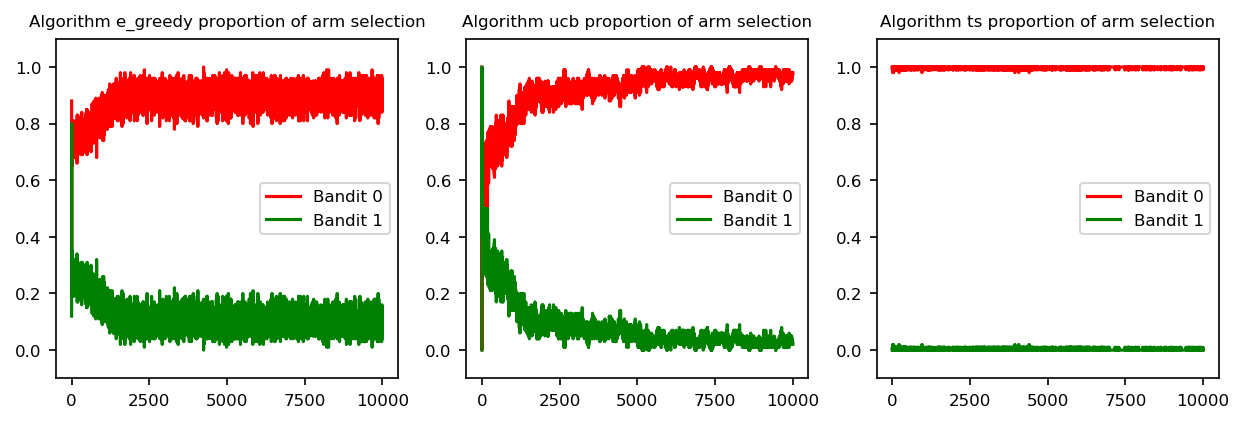

In [91]:
# closing all past figures
plt.close('all')

# opening figure to plot regret
plt.figure(figsize=(10, 3), dpi=150)

# colors for each bandit
bandit_colors = ['red', 'green', 'blue', 'purple']

# loop for each decision policy
for i, policy in enumerate(['e_greedy','ucb','ts']):
    
    # subplots
    plt.subplot(1,3,i+1)
    
    # loop for each arm
    for arm in range(N_BANDITS):
    
        # plotting data
        plt.plot(result_dict[policy]['k_array'][arm]/N_SIMULATIONS, label='Bandit {}'.format(arm), linewidth=1.5, color=bandit_colors[arm]);
    
        # adding title
        plt.title('Algorithm {} proportion of arm selection'.format(policy), fontsize=8)

        # adding legend
        plt.legend(fontsize=8); plt.xticks(fontsize=8); plt.yticks(fontsize=8); plt.ylim([-0.1,1.1])

# showing plot
plt.show()